In [1]:
# Standard library imports
import os
import random
import gc
import copy
import time

# Third-party library imports
import numpy as np
import pandas as pd

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# einops library for tensor operations
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# Custom TINTO library imports
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
import torch

# Get CUDA version
cuda_version = torch.version.cuda
print(f"CUDA Version: {cuda_version}")

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version()
print(f"cuDNN Version: {cudnn_version}")

# Get PyTorch version
pytorch_version = torch.__version__
print(f"PyTorch Version: {pytorch_version}")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use GPU.")
    
    # Get the name of the current GPU
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    
    # Create a random tensor and move it to GPU to verify
    x = torch.rand(5, 3)
    print(f"Is this tensor on GPU? {x.cuda().is_cuda}")
else:
    print("CUDA is not available. PyTorch will use CPU.")

# Additional check: is CUDA initialized?
print(f"Is CUDA initialized? {torch.cuda.is_initialized()}")

# Number of available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")

# Current device index
print(f"Current device index: {torch.cuda.current_device()}")


CUDA Version: 12.1
cuDNN Version: 90100
PyTorch Version: 2.5.1+cu121
CUDA is available. PyTorch can use GPU.
Current GPU: NVIDIA A100-PCIE-40GB MIG 7g.40gb
Is this tensor on GPU? True
Is CUDA initialized? True
Number of available GPUs: 1
Current device index: 0


## DATASET

In [4]:
SEED = 64
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
# Create variable to store dataset name
dataset_name = 'california_housing'
results_path = f'logs/Regression/{dataset_name}/MLP_Regression'

In [6]:
df = pd.read_csv(f"Datasets/Regression/{dataset_name}.csv")

In [7]:
df.shape

(20640, 9)

In [8]:
# Drop the second-to-last column if MIMO
# df = df.drop(df.columns[-1], axis=1)

In [9]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## LOAD AND PREPROCESS

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):

    # Generate the images if the folder does not exist
    if not os.path.exists(images_folder):
        #Generate thet images
        image_model.generateImages(df, images_folder)
    else:
        print("The images are already generated")

    img_paths = os.path.join(images_folder,problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, df], axis=1)

    # Split data
    df_x = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    df_y = combined_dataset["values"]
    
    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.20, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 

## MODEL ARCHITECTURES

In [11]:
class Model1(nn.Module):
    def __init__(self, attributes):
        super(Model1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(attributes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.layers(x)

In [12]:
class Model2(nn.Module):
    def __init__(self, attributes):
        super(Model2, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.mlp(x)

In [13]:
import torch
import torch.nn as nn

class Model3(nn.Module):
    def __init__(self, attributes, dropout=0.1):
        super(Model3, self).__init__()
        # MLP branch
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        
        # MLP branch 2
        self.mlp2 = nn.Sequential(
            nn.Linear(attributes, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        
        self.final_layers = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
    
    def forward(self, x):
        branch1_output = self.mlp(x)
        branch2_output = self.mlp2(x)
        merged = torch.cat((branch1_output, branch2_output), dim=1)
        return self.final_layers(merged)

## COMPILE AND FIT

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda'):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)

    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 20
    best_model = None
    best_epoch = 0
    warm_up_epochs = epochs*0.3

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, targets in train_loader:
            num_data, targets = num_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, targets in val_loader:
                num_data, targets = num_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(num_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            #early_stopping_counter = 0
        #else:
            #if epoch > warm_up_epochs:
                #early_stopping_counter += 1
                #if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered at epoch {epoch+1}")
                    #break

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save figures for this fold
    os.makedirs(f"models/Regression/{dataset_name}/MLP/{model_name}", exist_ok=True)
    plot_metric(history['train_loss'], history['val_loss'], 'Loss', dataset_name, model_name)
    plot_metric(history['train_mse'], history['val_mse'], 'MSE', dataset_name, model_name)
    plot_metric(history['train_rmse'], history['val_rmse'], 'RMSE', dataset_name, model_name)
    plot_learning_rate(history['learning_rate'], dataset_name, model_name)

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
            
    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, targets in data_loader:
            num_data, targets = num_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }    

def plot_metric(train_metric, val_metric, metric_name, dataset_name, model_name):
    plt.figure()
    plt.plot(train_metric, label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/MLP/{model_name}/{metric_name.lower()}_plot.png")
    plt.close()

def plot_learning_rate(learning_rates, dataset_name, model_name):
    plt.figure()
    plt.plot(learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/MLP/{model_name}/learning_rate_plot.png")
    plt.close()

In [15]:
def safe_compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=64, epochs=100, min_lr=1e-3, max_lr=1 , device='cuda'):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            # Compile and fit the model
            metrics = compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, epochs=epochs, min_lr=min_lr, max_lr=max_lr, device=device)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None
    finally:
        # Clear CUDA cache and force garbage collection
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

In [16]:
import traceback

def try_create_model(model_class, attributes):
    try:
        model = model_class(attributes)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        output = model(num_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [17]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_lr_finder import LRFinder

def run_lr_finder(model_class, attributes, imgs_shape, dataset_name, name, train_loader, val_loader, num_iter):

    # Define the path where the plot will be saved
    save_dir = os.path.join(f"logs/Regression/{dataset_name}/MLP/{name}")
    save_path = os.path.join(save_dir, 'lr_finder_plot.png')

    # Check if the file already exists
    if not os.path.exists(save_path):
        # Create and train Model
        model = try_create_model(model_class, attributes)
        
        if model is None:
            return None
        
        # Move model to device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=0.0001)
        criterion = nn.MSELoss()
        
        lr_finder = LRFinder(model, optimizer, criterion, device=device)
        lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1, num_iter=num_iter, step_mode="exp")
        
        axis, lr = lr_finder.plot()
        
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Get the figure from the axis and save it
        fig = axis.figure
        fig.savefig(save_path)
        print(f"Plot saved to: {save_path}")
        
        # Close the figure to ensure it's saved properly
        plt.close(fig)
        
        lr_finder.reset()
        print(f"Suggested learning rate: {lr}")
        
        return lr
    else:
        print(f"LR finder plot already exists at {save_path}. Skipping LR finder process.")
        # Load and display the existing image
        img = plt.imread(save_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title("Learning Rate Finder Plot")
        plt.show()
        
        return None  # Or you could return a default learning rate here

# Usage example:
# lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, name, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## EXPERIMENTS

In [18]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
#image_model = REFINED(problem= problem_type,hcIterations=5)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_TINTO"

In [19]:
def calculate_iterations_per_epoch(dataset_size, batch_size):
    iterations = dataset_size // batch_size
    if dataset_size % batch_size != 0:
        iterations += 1
    return iterations

In [20]:
batch_size = 32

In [21]:
num_epochs = calculate_iterations_per_epoch(df.shape[0], batch_size)
# For the Boston dataset, the number of samples is too small for a range test, so the number of epochs is tripled.
#num_epochs = num_epochs*3

In [22]:
num_epochs

645

### EXPERIMENT 1: MLP

In [23]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [24]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [25]:
# Start timing
start_time = time.time()

# Call the function
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    images_folder,
    image_model,
    problem_type,
    batch_size=batch_size
)

# End timing
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Data loading and preprocessing completed in {elapsed_time:.2f} seconds.")

The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/regression.csv
Images shape:  (3, 3, 3)
Attributes:  8
Data loading and preprocessing completed in 22.47 seconds.


Successfully created and tested Model1


  0%|          | 0/645 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.78E-03


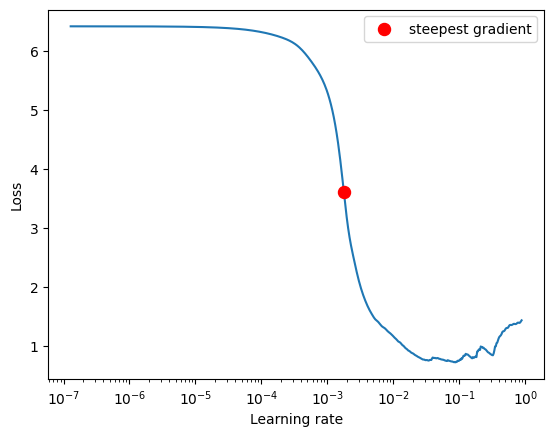

Plot saved to: logs/Regression/california_housing/MLP/Model1/lr_finder_plot.png
Suggested learning rate: 0.0017782794100389215


In [26]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"Model1", train_loader, val_loader, num_iter=num_epochs)

In [29]:
# Create and train Model1
model1 = try_create_model(Model1, attributes)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"Model1", min_lr=1e-4, max_lr=2e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 120.29 seconds
Best model found at epoch 100/100
Best Train Loss: 0.3215, Best Val Loss: 0.3261
Best Train MSE: 0.3215, Best Val MSE: 0.3271
Best Train RMSE: 0.5670, Best Val RMSE: 0.5719
Best model saved to models/Regression/california_housing/MLP/Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/645 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.82E-05


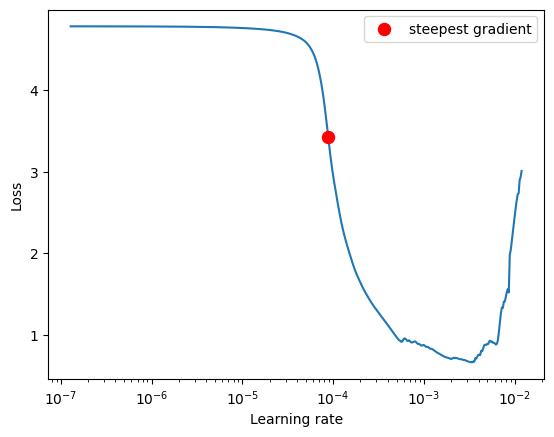

Plot saved to: logs/Regression/california_housing/MLP/Model2/lr_finder_plot.png
Suggested learning rate: 8.823729256112049e-05


In [27]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, attributes)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"Model2", min_lr=2e-5, max_lr=2e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 153.91 seconds
Best model found at epoch 100/100
Best Train Loss: 0.2653, Best Val Loss: 0.2529
Best Train MSE: 0.2653, Best Val MSE: 0.2533
Best Train RMSE: 0.5151, Best Val RMSE: 0.5033
Best model saved to models/Regression/california_housing/MLP/Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/645 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.08E-04


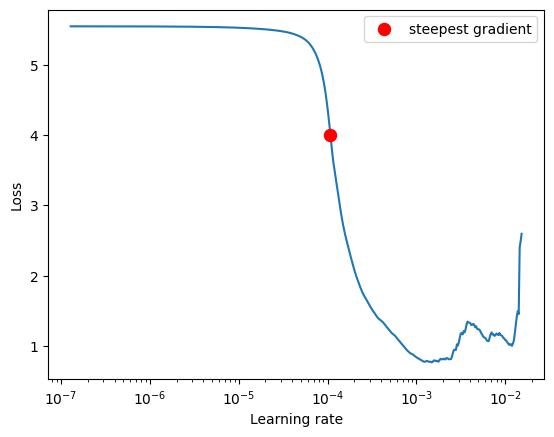

Plot saved to: logs/Regression/california_housing/MLP/Model3/lr_finder_plot.png
Suggested learning rate: 0.00010779750165872405


In [28]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"Model3", train_loader, val_loader, num_iter=num_epochs)

In [31]:
# Create and train Model3
model3 = try_create_model(Model3, attributes)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"Model3", min_lr=2e-5, max_lr=1e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 220.24 seconds
Best model found at epoch 93/100
Best Train Loss: 0.1976, Best Val Loss: 0.2351
Best Train MSE: 0.1976, Best Val MSE: 0.2356
Best Train RMSE: 0.4446, Best Val RMSE: 0.4854
Best model saved to models/Regression/california_housing/MLP/Model3/best_model.pth


In [32]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 0.3204080574503241, 'train_mse': 0.32040807604789734, 'train_mae': 0.3930532932281494, 'train_rmse': 0.5660460017064844, 'train_r2': 0.7584766149520874, 'val_loss': 0.3260958628012584, 'val_mse': 0.3271127939224243, 'val_mae': 0.3974679112434387, 'val_rmse': 0.5719377535382888, 'val_r2': 0.7484880089759827, 'test_loss': 0.3072700920013281, 'test_mse': 0.30828621983528137, 'test_mae': 0.38784676790237427, 'test_rmse': 0.5552352833126524, 'test_r2': 0.77994304895401, 'min_lr': 0.0001, 'max_lr': 0.02, 'total_time': 120.28554654121399, 'average_epoch_time': 1.2028518199920655}
Model 2 Metrics: {'train_loss': 0.22210269412675568, 'train_mse': 0.22210268676280975, 'train_mae': 0.3280353546142578, 'train_rmse': 0.4712777172356123, 'train_r2': 0.8325791358947754, 'val_loss': 0.2529443088632364, 'val_mse': 0.2532670497894287, 'val_mae': 0.3442080020904541, 'val_rmse': 0.503256445353091, 'val_r2': 0.8052668571472168, 'test_loss': 0.24896718802360387, 'test_mse': 0

## FINAL METRICS AND BEST MODEL

In [33]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [37]:
import os

def read_metrics(file_path):
    metrics = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.split(': ')
            metrics[key.strip()] = float(value.strip())
    return metrics

def rename_folder(old_folder_path, prefix):
    folder_name = os.path.basename(old_folder_path)
    new_folder_name = f"{prefix}_{folder_name}"
    parent_dir = os.path.dirname(old_folder_path)
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    os.rename(old_folder_path, new_folder_path)
    return new_folder_path

def process_folders(root_dir):
    prefixes = ["Model"]
    all_folders = []

    # Collect all folders that match the prefix
    for prefix in prefixes:
        matching_folders = [f for f in os.listdir(root_dir) if f.startswith(prefix) and os.path.isdir(os.path.join(root_dir, f))]
        for folder in matching_folders:
            metrics_file = os.path.join(root_dir, folder, 'metrics.txt')
            if os.path.exists(metrics_file):
                metrics = read_metrics(metrics_file)
                all_folders.append((folder, metrics['test_rmse']))
    
    # Sort all folders by their test_rmse
    all_folders.sort(key=lambda x: x[1])
    
    # Rename the top 3 folders as TOP1, TOP2, TOP3
    for i, (folder, _) in enumerate(all_folders[:3], start=1):
        rename_folder(os.path.join(root_dir, folder), f"TOP{i}")
    
    return all_folders[:3]

# Example usage:
# root_dir = "/path/to/your/directories"
# process_folders(root_dir)


In [38]:
base_path = f"logs/Regression/{dataset_name}/MLP/"

# Process the folders and get the top 3 models
top_folders = process_folders(base_path)

# Print the top 3 folders with their test RMSE values
print("Top 3 model folders:")
for rank, (folder, rmse) in enumerate(top_folders, start=1):
    print(f"TOP{rank}: {folder}, Test RMSE: {rmse}")

Top 3 model folders:
TOP1: Model3, Test RMSE: 0.4856941503094762
TOP2: Model2, Test RMSE: 0.49897288086880437
TOP3: Model1, Test RMSE: 0.5552352833126524
